## Install Dependencies and Setup

In [2]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import albumentations as alb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model

## Load Image into TF Data Pipeline

In [3]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

## Load Augmented Images to Tensorflow Dataset

In [4]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [7]:
train_images.as_numpy_iterator().next()

array([[[0.15367647, 0.14154412, 0.10606617],
        [0.15343137, 0.17598039, 0.16617647],
        [0.16599265, 0.24099265, 0.2836397 ],
        ...,
        [0.45802698, 0.43020833, 0.44852942],
        [0.44099265, 0.4213848 , 0.4454044 ],
        [0.41311276, 0.41887254, 0.41697302]],

       [[0.2077206 , 0.12616421, 0.17732844],
        [0.16415441, 0.12181372, 0.18566176],
        [0.21115196, 0.19895834, 0.28621325],
        ...,
        [0.48645833, 0.44295344, 0.4747549 ],
        [0.4764706 , 0.43425244, 0.46605393],
        [0.45533088, 0.41066176, 0.44362745]],

       [[0.18713236, 0.16997549, 0.22714461],
        [0.21004902, 0.18057598, 0.25226715],
        [0.27107844, 0.20232843, 0.29699755],
        ...,
        [0.46158087, 0.41170344, 0.43860295],
        [0.4372549 , 0.39607844, 0.4269608 ],
        [0.4488358 , 0.3981005 , 0.44319853]],

       ...,

       [[0.2666054 , 0.14142157, 0.24583334],
        [0.30232844, 0.2106005 , 0.26862746],
        [0.18216912, 0

## Build Label Loading Function

In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

## Load Labels to Tensorflow Dataset

In [9]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [12]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.583 , 0.4568, 0.8994, 0.837 ], dtype=float16))

## Check Partition Lengths

In [13]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3480, 3480, 780, 780, 780, 780)

## Create Final Datasets (Images/Labels)

In [14]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1000)
test = test.batch(8)
test = test.prefetch(4)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [15]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.278  , 0.12445, 0.5864 , 0.5576 ],
        [0.46   , 0.188  , 0.7495 , 0.4116 ],
        [0.4182 , 0.401  , 0.7583 , 0.772  ],
        [0.12476, 0.1531 , 0.4417 , 0.609  ],
        [0.     , 0.4807 , 0.2279 , 0.8433 ],
        [0.13   , 0.1562 , 0.49   , 0.4832 ],
        [0.1477 , 0.4924 , 0.4646 , 0.9023 ],
        [0.04984, 0.1659 , 0.3394 , 0.5903 ]], dtype=float16))

## View Images and Annotations

In [16]:
data_samples = train.as_numpy_iterator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


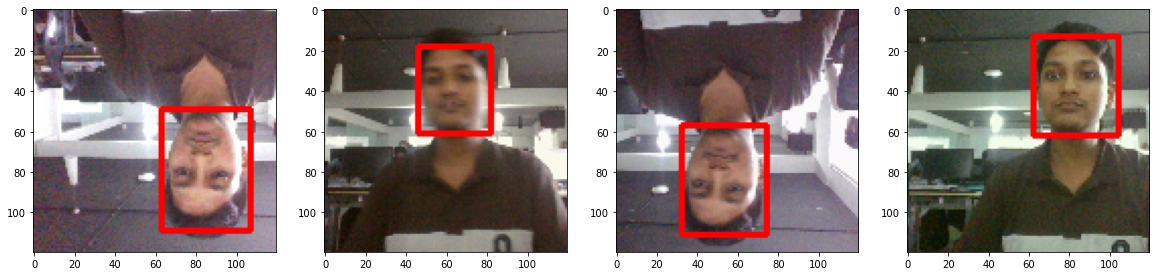

In [17]:
res = data_samples.next()


fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## Download VGG16

In [18]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Build instance of Network

In [19]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

## Test out Neural Network

In [20]:
facetracker = build_model()
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [21]:
X, y = train.as_numpy_iterator().next()
X.shape

(8, 120, 120, 3)

In [22]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 548ms/step


In [23]:
classes, coords

(array([[0.5512197 ],
        [0.4991044 ],
        [0.5741377 ],
        [0.5861829 ],
        [0.49124706],
        [0.60107917],
        [0.5739205 ],
        [0.66498846]], dtype=float32),
 array([[0.43920237, 0.5361229 , 0.5236851 , 0.59382313],
        [0.52216023, 0.5280504 , 0.50383544, 0.63070345],
        [0.49801394, 0.50736904, 0.5107609 , 0.65062463],
        [0.43466824, 0.5183174 , 0.51886374, 0.6355715 ],
        [0.4610754 , 0.49890628, 0.53371686, 0.59603393],
        [0.3986313 , 0.43586034, 0.5842644 , 0.6289306 ],
        [0.48934382, 0.5340956 , 0.5267372 , 0.5896605 ],
        [0.3894431 , 0.47098294, 0.4539918 , 0.5290022 ]], dtype=float32))

## Define Optimizer and LR

In [24]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

## Create Localization Loss and Classification Loss

In [25]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [26]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## Test out Loss Metrics

In [27]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.227075>

In [28]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.60756516>

In [29]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.227075>

## Create Custom Model Class

In [30]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [31]:
model = FaceTracker(facetracker)

In [32]:
model.compile(opt, classloss, regressloss)

## Train

In [33]:
logdir='logs'

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [35]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

## Plot Performance

In [36]:
hist.history

In [37]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## Make Predictions on Test Set

In [38]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])

In [39]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## Save the Model

In [43]:
facetracker.save('facetracker.h5')

In [44]:
facetracker = load_model('facetracker.h5')

## Convert to tf lite

In [6]:
lite_model_dir = tf.keras.models.load_model('./facetracker.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(lite_model_dir)
tflite_model = converter.convert()
open("facetracker.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\BS898\AppData\Local\Temp\tmp0snlxkca\assets


INFO:tensorflow:Assets written to: C:\Users\BS898\AppData\Local\Temp\tmp0snlxkca\assets


67315492

## Real Time Detection

In [45]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500, :]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 74ms/step
